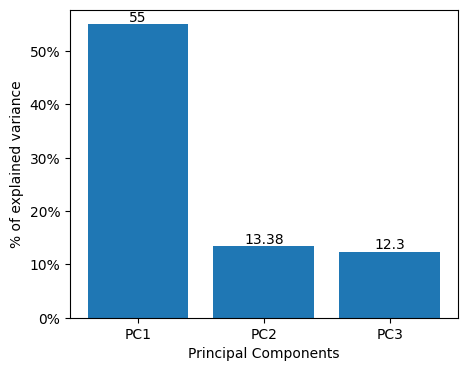

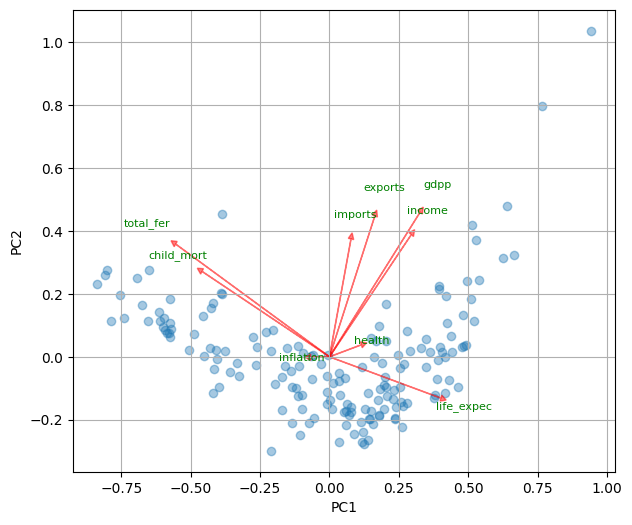

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scripts import *
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

import warnings
warnings.filterwarnings('ignore')


raw_df = pd.read_csv('../data/country-data.csv')
countries, df_pca, explained_variance = pre_process_data(raw_df, 
                                                         scaler = 'minmax', 
                                                         pca = True,
                                                         biplot = True, 
                                                         plot_scree_plot = True, 
                                                         pca_components = 3,
                                                         plot_pc=("PC1", 'PC2'))

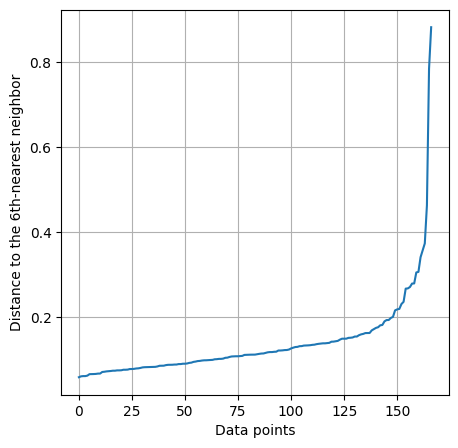

In [2]:
dbscan_epsilon(df_pca, min_samples = 6)

In [13]:
dbscan = DBSCAN(eps=0.14, min_samples=6)
dbscan.fit_predict(df_pca)
df_pca['cluster'] = dbscan.labels_

clustered_df, pivot = pivot_table(df_pca, raw_df)

s = cal_silhouette(clustered_df.drop("country", axis=1))
print(s)
scatter_plot_data(df_pca, ['PC1','PC2', 'PC3'], countries, three=True)
#create_map_plot(clustered_df)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
-1,45.781250,58.478750,8.063437,62.578125,29553.875000,8.493156,68.743750,3.430625,23672.343750
0,87.683333,25.524583,5.340000,35.275000,2816.583333,12.978125,60.254167,5.045000,1231.333333
1,21.229545,41.193057,6.172159,46.875749,13633.295455,7.408568,73.275000,2.232159,7550.590909
2,4.147059,35.664706,10.318235,34.588235,37794.117647,1.340353,80.988235,1.724118,41770.588235
3,147.166667,25.000000,5.578333,44.750000,1268.500000,6.928333,51.983333,5.951667,565.833333


-0.16169108760322062


In [12]:
dbscan = DBSCAN(eps=0.14, min_samples=8)
dbscan.fit_predict(df_pca)
df_pca['cluster'] = dbscan.labels_

clustered_df, pivot = pivot_table(df_pca, raw_df)

s = cal_silhouette(clustered_df.drop("country", axis=1))
print(s)
scatter_plot_data(df_pca, ['PC1','PC2', 'PC3'], countries, three=True)
#create_map_plot(clustered_df)

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
-1,61.789474,53.192632,7.671053,59.763158,25087.763158,8.246079,66.097368,3.828684,20023.947368
0,21.229545,41.193057,6.172159,46.875749,13633.295455,7.408568,73.275000,2.232159,7550.590909
1,4.147059,35.664706,10.318235,34.588235,37794.117647,1.340353,80.988235,1.724118,41770.588235
2,87.683333,25.524583,5.340000,35.275000,2816.583333,12.978125,60.254167,5.045000,1231.333333


-0.04159563311576489


,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
cluster,,,,,,,,,
-1,67.184615,41.636923,6.422885,47.375000,15618.076923,11.732096,64.215385,3.934808,12254.788462
0,17.963380,42.707042,6.460000,49.488732,14062.535211,7.020056,73.846479,2.218592,7364.084507
1,4.600000,53.323529,9.850000,47.229412,44782.352941,1.493765,80.841176,1.778235,44994.117647
2,113.857143,28.642857,6.238571,39.571429,1540.428571,8.075714,57.342857,5.810000,711.714286
3,4.162500,38.337500,8.860000,40.300000,30412.500000,1.394875,80.487500,1.707500,27587.500000
4,62.116667,16.781667,6.440000,41.683333,1758.333333,4.743333,62.433333,4.498333,819.166667
5,56.816667,25.581500,4.155000,33.510983,4441.666667,11.588333,67.716667,3.105000,1569.666667


-0.243604803296424


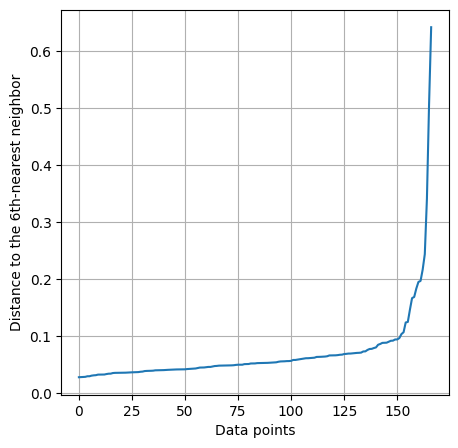

In [33]:
health_features = ['child_mort', 'life_expec', 'gdpp']
df_pca = pre_process_data(raw_df[health_features], scaler = 'minmax', pca = True, biplot = False, plot_scree_plot = False, pca_components = 3)

dbscan_epsilon(df_pca, min_samples = 6)

dbscan = DBSCAN(eps=0.05, min_samples=6)
dbscan.fit_predict(df_pca)
df_pca['cluster'] = dbscan.labels_

clustered_df, pivot = pivot_table(df_pca, raw_df)

s = cal_silhouette(clustered_df.drop("country", axis=1))
print(s)
scatter_plot_data(df_pca, ['PC1','PC2', 'PC3'], countries, three=True)
#create_map_plot(clustered_df)

# DBSCAN Clustering algorithm

DBSCAN works as following:
- For each instance in the data, the algorithm counts how many instances are located within a small distance $\epsilon$ (epsilon) from it. So, in 3-dimensional space, that would be the radius a sphere.
- If an instance has at least `min_samples` instances in its $\epsilon$-neighborhood (including itself), then it is considered a *core instance*. In other words; core instances are those that are located in dense regions.
- All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.
- Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.
  

# Determine the optimal value for $\epsilon$

## Nereast neighbours approach

Source:
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

To determine a a good value for $\epsilon$, we find a suitable value for $\epsilon$ by calculating the distance to the nearest $n$ points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced and select that as $\epsilon$.

we can calculate the distance from each point to its closest neighbour using the `NearestNeighbors`. The point itself is included in `n_neighbors`. The `kneighbors` method returns two arrays, one which contains the distance to the closest `n_neighbors` points and the other which contains the index for each of those points.

Source: https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan?rq=1

eps hyperparameter

In order to determine the best value of eps for your dataset, use the K-Nearest Neighbours approach as explained in these two papers: Sander et al. 1998 and Schubert et al. 2017 (both papers from the original DBSCAN authors).

Here's a condensed version of their approach: If you have N-dimensional data to begin, then choose n_neighbors in sklearn.neighbors.NearestNeighbors to be equal to 2xN - 1, and find out distances of the K-nearest neighbors (K being 2xN - 1) for each point in your dataset. Sort these distances out and plot them to find the "elbow" which separates noisy points (with high K-nearest neighbor distance) from points (with relatively low K-nearest neighbor distance) which will most likely fall into a cluster. The distance at which this "elbow" occurs is your point of optimal eps.

Here's some python code to illustrate how to do this:

In [4]:
# def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

#     nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

#     # For each point, compute distances to its k-nearest neighbors
#     distances, indices = nbrs.kneighbors(X) 
                                       
#     distances = np.sort(distances, axis=0)
#     distances = distances[:, k-1]

#     # Plot the sorted K-nearest neighbor distance for each point in the dataset
#     plt.figure(figsize=(8,8))
#     plt.plot(distances)
#     plt.xlabel('Points/Objects in the dataset', fontsize=12)
#     plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
#     plt.grid(True, linestyle="--", color='black', alpha=0.4)
#     # plt.axhline(y=0.2, linewidth=1, linestyle='dashed', color='k')
#     plt.show()
#     plt.close()


# k = 2 * df_pca.shape[-1] - 1 # k=2*{dim(dataset)} - 1
# # print(k)
# get_kdist_plot(X=df_pca, k=k)


In [5]:
# df_pca['country'] = countries
# compponents, df_pca = apply_dbscan(df_pca, eps = 0.2, min_samples = 6)
# cl_perc =  df_pca.groupby('cluster').count()
# cl_perc['perc']  = 100 * df_pca.groupby('cluster').count().country / 167
# cl_perc
# scatter_plot_data(df_pca, ['PC1', 'PC2'], countries)

# Run DBSCAN algorithm

In [6]:

dbscan = DBSCAN(eps=0.05, min_samples=6) 
dbscan.fit(scaled_pca_df)

labels = dbscan.labels_ # cluster labels for each country
core_indices = dbscan.core_sample_indices_ # indices of the core samples
n_core = len(core_indices) # number of countries considered a "core" samples
number_of_anomalies = len([x for x in labels if x == -1]) # number of countries considered an "outlier"
number_of_clusters = len(set(labels)) - (1 if -1 in labels else 0) # number of clusters
n_points_clusters = OrderedDict(Counter(sorted(labels)))
components = dbscan.components_ # values of the core samples

print("Labels:\n", labels)
print("Core indices:\n", core_indices)
print(n_core, "core samples")
print(number_of_anomalies, "anomalies")
print(number_of_clusters, "clusters")
print(n_points_clusters, "points distribution")

anomaly_countries = []
for i in range(len(labels)):
    if labels[i] == -1:
        anomaly_countries.append(countries[i])

NameError: name 'scaled_pca_df' is not defined

In [ ]:
for i in range(-1, number_of_clusters):
    print("Cluster", i, "\n")
    for j in range(len(labels)):
        if labels[j] == i:
            print(countries[j])

Cluster -1 

Cluster 0 

Afghanistan
Albania
Algeria
Angola
Antigua and Barbuda
Argentina
Armenia
Australia
Austria
Azerbaijan
Bahamas
Bahrain
Bangladesh
Barbados
Belarus
Belgium
Belize
Benin
Bhutan
Bolivia
Bosnia and Herzegovina
Botswana
Brazil
Brunei
Bulgaria
Burkina Faso
Burundi
Cambodia
Cameroon
Canada
Cape Verde
Central African Republic
Chad
Chile
China
Colombia
Comoros
Congo, Dem. Rep.
Congo, Rep.
Costa Rica
Cote d'Ivoire
Croatia
Cyprus
Czech Republic
Denmark
Dominican Republic
Ecuador
Egypt
El Salvador
Equatorial Guinea
Eritrea
Estonia
Fiji
Finland
France
Gabon
Gambia
Georgia
Germany
Ghana
Greece
Grenada
Guatemala
Guinea
Guinea-Bissau
Guyana
Haiti
Hungary
Iceland
India
Indonesia
Iran
Iraq
Ireland
Israel
Italy
Jamaica
Japan
Jordan
Kazakhstan
Kenya
Kiribati
Kuwait
Kyrgyz Republic
Lao
Latvia
Lebanon
Lesotho
Liberia
Libya
Lithuania
Luxembourg
Macedonia, FYR
Madagascar
Malawi
Malaysia
Maldives
Mali
Malta
Mauritania
Mauritius
Micronesia, Fed. Sts.
Moldova
Mongolia
Montenegro
Morocco
M

# HDBSCAN

In [ ]:
from scripts import *

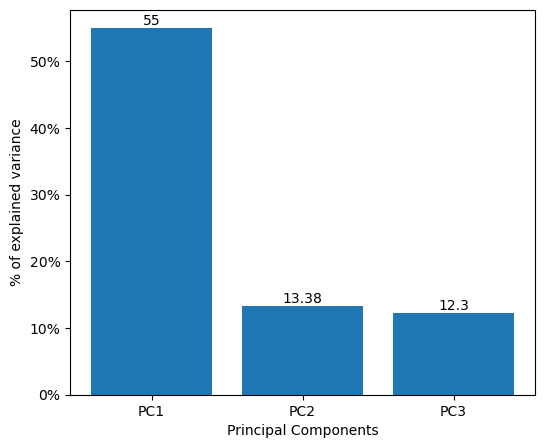

In [ ]:
raw_data = pd.read_csv('../data/country-data.csv')
countries, df, explained_variance = pre_process_data(raw_data, 'minmax', pca=True, pca_components=3, plot_scree_plot=True)


In [ ]:
## DBSCAN with eps=0.08 and min_samples=4
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.12, min_samples=4)
dbscan.fit_predict(df)
labels = dbscan.labels_
df['cluster'] = labels
core_indices = dbscan.core_sample_indices_
n_core = len(core_indices)
number_of_anomalies = len([x for x in labels if x == -1])
number_of_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#n_points_clusters = OrderedDict(Counter(sorted(labels)))
components = dbscan.components_

In [ ]:
#df_pivot = df.drop('-1',axis=0).pivot_table(index='cluster', aggfunc='mean')
### drop if cluster is -1
df_pivot = df[df.cluster != -1].pivot_table(index='cluster', aggfunc='mean')
df_pivot

,PC1,PC2,PC3
cluster,,,
0,-0.0361560,-0.0730999,-0.0449207
1,0.4438611,0.0208419,0.2533926
2,-0.7750412,0.2070509,0.0586099


In [ ]:
df['country'] = countries
df = df[df['cluster'] != -1]
countries = df['country']

In [ ]:
scatter_plot_data(df, ['PC1', 'PC3'], countries)

In [ ]:
### implement hdbscan
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=2)
clusterer.fit_predict(df)

array([ 3,  5,  5, -1,  5,  5,  5,  0,  0,  5,  5,  5,  5,  5,  5,  0,  5,
        3,  5,  5,  5,  5,  5, -1,  5,  3, -1,  5,  3,  0,  5,  1,  1,  5,
        5,  5,  2,  1, -1,  5,  3,  5,  4,  4,  0,  5,  5,  5,  5, -1, -1,
        5,  5,  0,  0,  5,  3,  5,  0,  2,  0,  5,  5,  3,  3,  5,  1,  5,
        0,  5,  5,  5,  5, -1, -1,  0,  5,  0, -1,  5,  2, -1, -1,  5, -1,
        5,  5, -1, -1,  5,  5, -1,  5,  2,  3, -1,  5,  1, -1, -1,  5, -1,
        5,  5,  5,  5,  3, -1,  5,  5,  0,  0,  1,  1, -1,  5,  2, -1,  5,
        5,  5,  5,  0, -1,  5,  5, -1,  5, -1,  2,  5, -1, -1, -1,  4, -1,
        5, -1,  4,  0, -1,  5, -1,  5,  0, -1,  5,  3, -1, -1, -1,  5,  5,
        5, -1,  3,  5, -1,  0, -1,  5,  5,  5,  5,  5,  2,  3])